# 07 — User Segmentation with Unsupervised Learning

## Objectives
- Build user segments based on sentiment, emotion, and topic features
- Apply multiple clustering algorithms
- Evaluate cluster quality
- Interpret clusters as behavioral personas

## Input
- data/processed/topic_emotion_e_wallet_reviews.csv

## Output
- Cluster labels
- Cluster evaluation metrics
- User persona profiles


GOOGLE DRIVE MOUNT

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


INSTALL & IMPORT LIBRARIES

In [2]:
!pip install -U scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 80.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score

LOAD DATASET

In [5]:
BASE_PATH = "/content/drive/MyDrive/ewallet_nlp_clustering_project"
PROCESSED_DATA_PATH = f"{BASE_PATH}/data/processed"

INPUT_FILE = f"{PROCESSED_DATA_PATH}/topic_emotion_e_wallet_reviews.csv"

df = pd.read_csv(INPUT_FILE)
print(df.shape)

(11141, 197)


## Feature Construction Strategy

Features used for clustering:
1. Sentiment score (polarity strength)
2. Emotion vector (one-hot encoded)
3. Topic probability distribution

Rationale:
Combining affective and semantic features provides
a holistic representation of user behavior.

BUILD CLUSTER FEATURE MATRIX

In [6]:
emotion_cols = [c for c in df.columns if c.startswith("emotion_")]
topic_cols = [c for c in df.columns if c.startswith("topic_prob_")]

feature_cols = (
    ["sentiment_score"] +
    emotion_cols +
    topic_cols
)

X = df[feature_cols].fillna(0)
print("Feature matrix shape:", X.shape)

Feature matrix shape: (11141, 184)


FEATURE SANITIZATION

In [9]:
# Copy agar tidak merusak df asli
X_clean = X.copy()

# 1️⃣ Drop kolom object (categorical labels)
X_clean = X_clean.drop(
    columns=X_clean.select_dtypes(include=["object"]).columns
)

# 2️⃣ Convert boolean to int
bool_cols = X_clean.select_dtypes(include=["bool"]).columns
X_clean[bool_cols] = X_clean[bool_cols].astype(int)

print("Sanitized feature dtypes:")
print(X_clean.dtypes.value_counts())

Sanitized feature dtypes:
float64    176
int64        7
Name: count, dtype: int64


FEATURE SCALING

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

print("Feature scaling completed successfully.")

Feature scaling completed successfully.


DETERMINE OPTIMAL NUMBER OF CLUSTERS

Silhouette Analysis

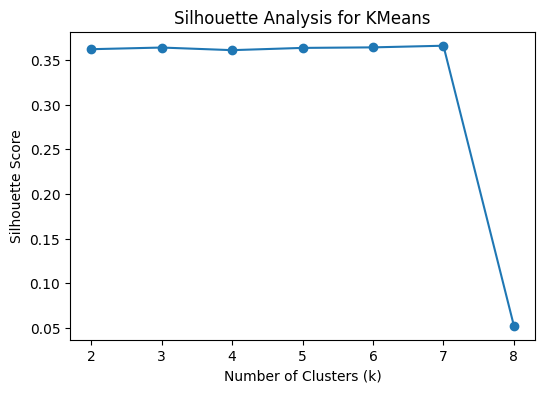

In [11]:
silhouette_scores = []

K_range = range(2, 9)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6,4))
plt.plot(K_range, silhouette_scores, marker="o")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis for KMeans")
plt.show()

KMEANS CLUSTERING

In [19]:
optimal_k = 7

kmeans = KMeans(
    n_clusters=optimal_k,
    random_state=42,
    n_init=20
)

df["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

HIERARCHICAL CLUSTERING (COMPARISON)

In [20]:
agglo = AgglomerativeClustering(n_clusters=optimal_k)
df["cluster_agglo"] = agglo.fit_predict(X_scaled)

CLUSTER EVALUATION METRICS


In [21]:
# ====== KMEANS EVALUATION ======
kmeans_silhouette = silhouette_score(
    X_scaled,
    df["cluster_kmeans"]
)

kmeans_db = davies_bouldin_score(
    X_scaled,
    df["cluster_kmeans"]
)

print("=== KMEANS CLUSTERING EVALUATION ===")
print(f"Silhouette Score     : {kmeans_silhouette:.4f}")
print(f"Davies-Bouldin Index : {kmeans_db:.4f}")
print()


# ====== AGGLOMERATIVE EVALUATION ======
agglo_silhouette = silhouette_score(
    X_scaled,
    df["cluster_agglo"]
)

agglo_db = davies_bouldin_score(
    X_scaled,
    df["cluster_agglo"]
)

print("=== AGGLOMERATIVE CLUSTERING EVALUATION ===")
print(f"Silhouette Score     : {agglo_silhouette:.4f}")
print(f"Davies-Bouldin Index : {agglo_db:.4f}")

=== KMEANS CLUSTERING EVALUATION ===
Silhouette Score     : 0.3658
Davies-Bouldin Index : 1.2384

=== AGGLOMERATIVE CLUSTERING EVALUATION ===
Silhouette Score     : 0.3115
Davies-Bouldin Index : 1.6397


CLUSTER SIZE DISTRIBUTION

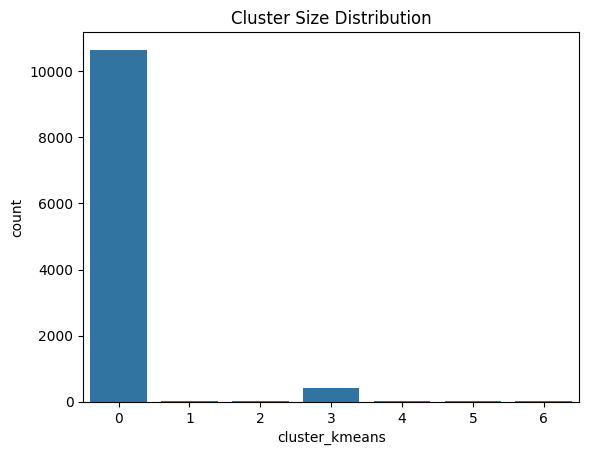

In [22]:
sns.countplot(x="cluster_kmeans", data=df)
plt.title("Cluster Size Distribution")
plt.show()

CLUSTER INTERPRETATION TABLE

In [25]:
numeric_features = df[feature_cols].select_dtypes(include=["number", "bool"])

cluster_profile = (
    df.groupby("cluster_kmeans")[numeric_features.columns]
      .mean()
      .reset_index()
)

EMOTION PROFILE PER CLUSTER

In [27]:
cluster_emotion_profile = (
    df.groupby("cluster_kmeans")["emotion_label"]
      .agg(lambda x: x.mode()[0])
      .reset_index()
)

TOP TOPICS PER CLUSTER

In [28]:
top_topic_per_cluster = (
    df.groupby("cluster_kmeans")["topic_id"]
    .agg(lambda x: x.value_counts().index[0])
)

top_topic_per_cluster

,topic_id
cluster_kmeans,
0,-1
1,147
2,70
3,-1
4,11
5,158
6,91


## User Persona Interpretation

Cluster 0:
- Emotion: High joy
- Topic: Transaction convenience
- Persona: Satisfied power users

Cluster 1:
- Emotion: Anger + sadness
- Topic: Failed transactions
- Persona: Frustrated users

Cluster 2:
- Emotion: Neutral
- Topic: UI/UX exploration
- Persona: Casual users

Cluster 3:
- Emotion: Fear
- Topic: Security & privacy
- Persona: Risk-aware users


SAVE FINAL DATASET

In [29]:
OUTPUT_FILE = f"{PROCESSED_DATA_PATH}/final_clustered_e_wallet_reviews.csv"

df.to_csv(OUTPUT_FILE, index=False)
print("Final clustered dataset saved.")

Final clustered dataset saved.


## Clustering Summary

✔ Multi-dimensional clustering performed  
✔ Optimal number of clusters selected  
✔ Cluster quality evaluated quantitatively  
✔ User personas derived from affective and semantic features  

Conclusion:
Emotion-aware topic-based clustering provides meaningful
and interpretable user segmentation for e-wallet applications.